In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm_notebook

In [2]:
file = './data/continuous_factory_process.csv'

In [6]:
df = pd.read_csv(file, parse_dates=['time_stamp'])
df = df.sort_values('time_stamp')

In [9]:
df.head()

,time_stamp,AmbientConditions.AmbientHumidity.U.Actual,AmbientConditions.AmbientTemperature.U.Actual,Machine1.RawMaterial.Property1,Machine1.RawMaterial.Property2,Machine1.RawMaterial.Property3,Machine1.RawMaterial.Property4,Machine1.RawMaterialFeederParameter.U.Actual,Machine1.Zone1Temperature.C.Actual,Machine1.Zone2Temperature.C.Actual,...,Stage2.Output.Measurement10.U.Actual,Stage2.Output.Measurement10.U.Setpoint,Stage2.Output.Measurement11.U.Actual,Stage2.Output.Measurement11.U.Setpoint,Stage2.Output.Measurement12.U.Actual,Stage2.Output.Measurement12.U.Setpoint,Stage2.Output.Measurement13.U.Actual,Stage2.Output.Measurement13.U.Setpoint,Stage2.Output.Measurement14.U.Actual,Stage2.Output.Measurement14.U.Setpoint
0,2019-03-06 10:52:33,17.24,23.53,11.54,200,963.0,247,1241.26,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
1,2019-03-06 10:52:34,17.24,23.53,11.54,200,963.0,247,1246.09,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
2,2019-03-06 10:52:35,17.24,23.53,11.54,200,963.0,247,1246.29,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
3,2019-03-06 10:52:36,17.24,23.53,11.54,200,963.0,247,1247.59,72.0,72.3,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71
4,2019-03-06 10:52:37,17.24,23.53,11.54,200,963.0,247,1252.83,72.1,72.4,...,0.0,7.93,0.0,5.65,0.0,1.85,0.0,2.89,0.0,11.71


In [10]:
df['y'] = df['Stage1.Output.Measurement0.U.Actual'] - df['Stage1.Output.Measurement0.U.Setpoint']

In [12]:
features = df.iloc[:,1:42]
y = df['y']

In [14]:
from lightgbm import LGBMRegressor

In [15]:
features.shape

(14088, 41)

In [16]:
Xtrain, Xval = features.iloc[:7000], features.iloc[7000:]
ytrain, yval = y.iloc[:7000], y.iloc[7000:]

In [17]:
mdl = LGBMRegressor(random_state=0)

In [18]:
mdl.fit(Xtrain,ytrain)
p=mdl.predict(Xval)

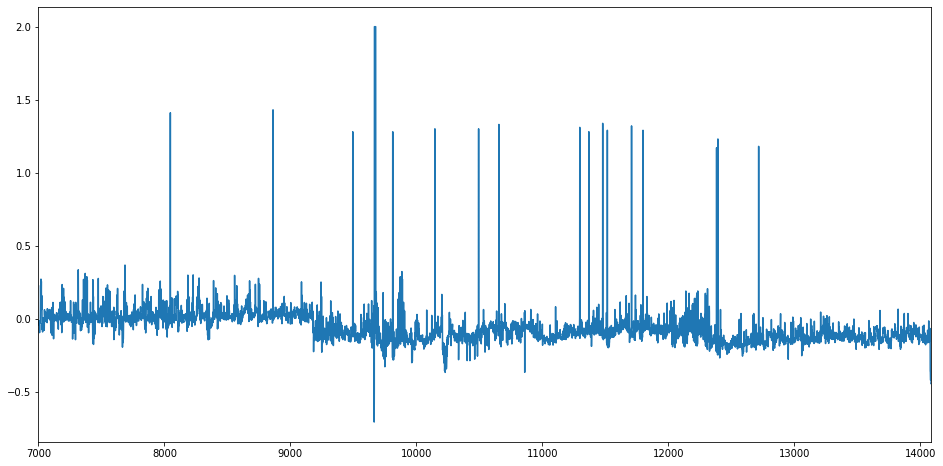

In [19]:
naive_error = (yval-p).clip(upper=2)
naive_error.plot(figsize=(16,8))

In [20]:
from sklearn.metrics import mean_absolute_error, median_absolute_error

In [22]:
## Baseline
p_base = ytrain.mean() * np.ones(yval.shape[0])
mean_absolute_error(yval, p_base), median_absolute_error(yval, p_base)

(0.07976598605663952, 0.04836065519425792)

In [24]:
mdl = LGBMRegressor(n_estimators=100, learning_rate=0.003, num_leaves=2**6, subsample=0.75, subsample_freq=1, colsample_bytree=1,
                   random_state=0)

In [25]:
mdl.fit(Xtrain,ytrain)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
              importance_type='split', learning_rate=0.003, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=64, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=0.75, subsample_for_bin=200000, subsample_freq=1)

In [26]:
p = mdl.predict(Xval)

In [27]:
## First Model error after baseline 
mean_absolute_error(yval, p), median_absolute_error(yval,p)

(0.06944799091304188, 0.04691723890488908)

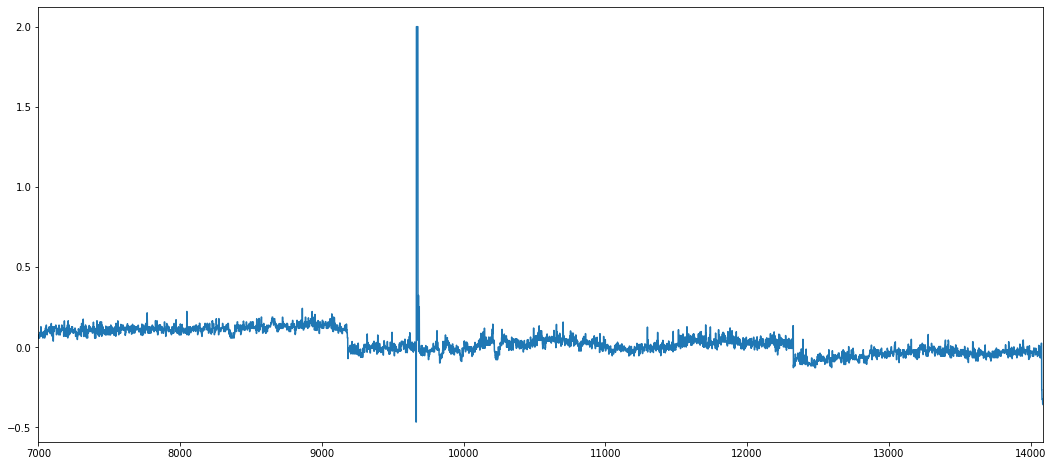

In [28]:
error = (yval-p).clip(upper=2)
error.plot(figsize=(18,8))

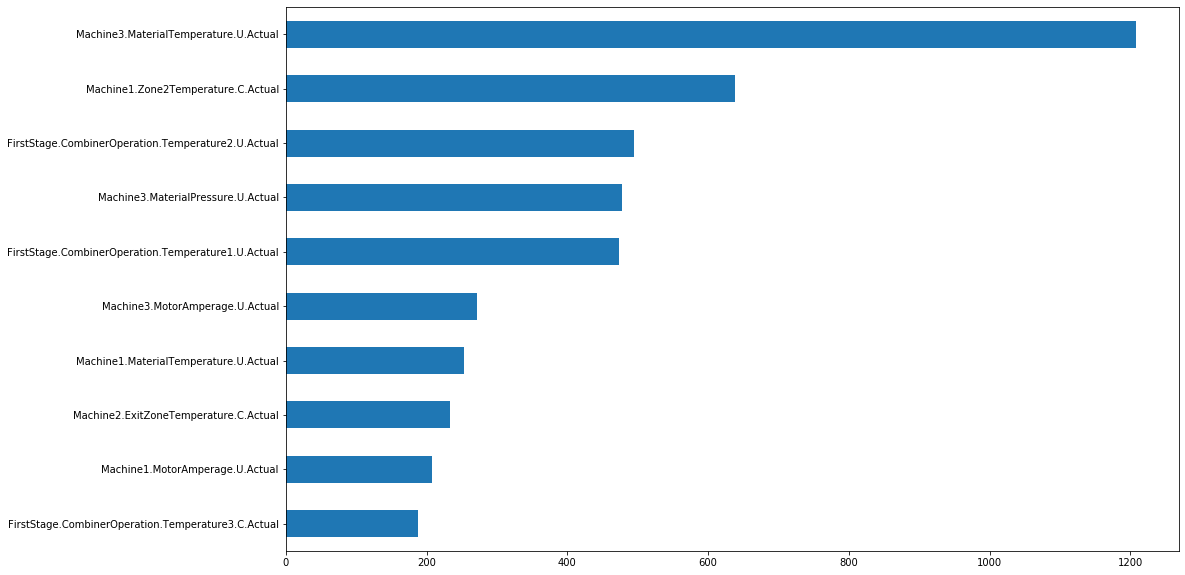

In [33]:
## Features Importances
pd.Series(mdl.feature_importances_, index=Xtrain.columns).sort_values().tail(10).plot.barh(figsize=(16,10))

In [37]:
import shap
shap.initjs()

In [40]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(Xtrain)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


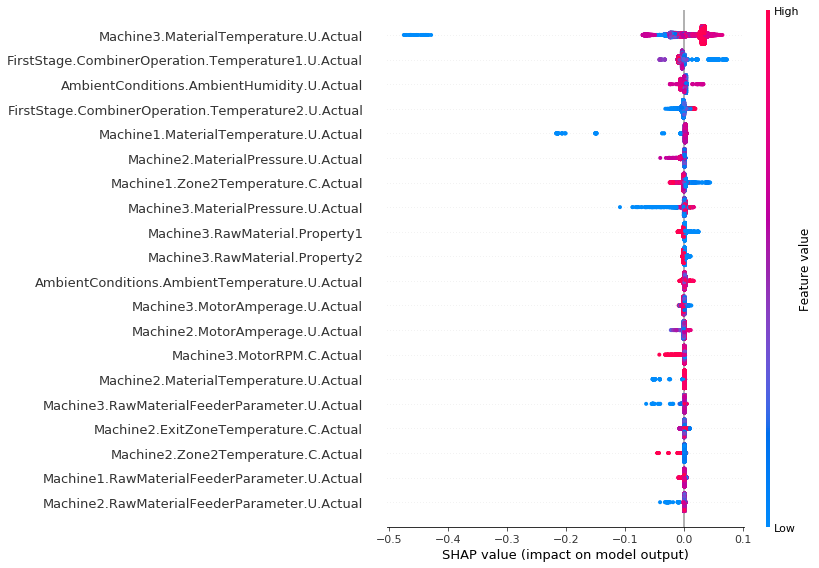

In [42]:
shap.summary_plot(shap_values,Xtrain)

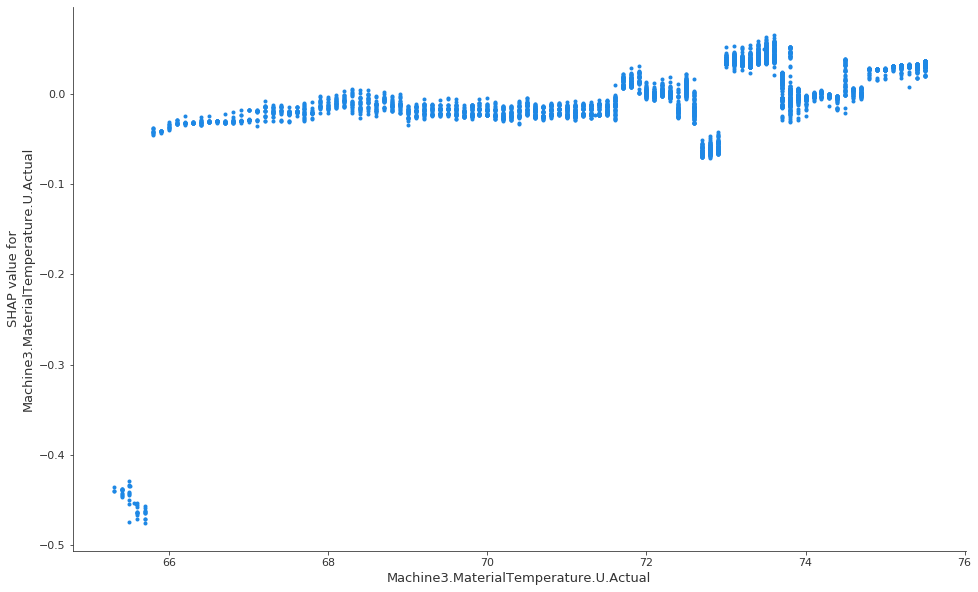

In [52]:
f, a = plt.subplots(1,1,figsize=(16,10))
shap.dependence_plot('Machine3.MaterialTemperature.U.Actual', shap_values, Xtrain,ax=a, interaction_index=None)

In [54]:
from itertools import combinations

In [63]:
combos_ = []

for f1,f2 in tqdm_notebook(combinations(Xtrain.columns,2)):
    
    f1_ = Xtrain[f1].corr(ytrain)
    f2_ = Xtrain[f2].corr(ytrain)
    f1_f2 = (Xtrain[f2]-Xtrain[f1]).corr(ytrain)
    best_single = max(abs(f1_),abs(f2_))
    combo_score = abs(f1_f2)
    
    res = dict()
    res['f1'] = f1
    res['f2'] = f2
    res['f1_'] = f1_
    res['f2_'] = f2_
    res['f1_f2_'] = f1_f2
    res['f1_f2'] = combo_score - best_single
    
    combos_.append(res)

In [64]:
df_combos = pd.DataFrame(combos_).sort_values('f1_f2', ascending=True)
df_combos = df_combos[df_combos['f1_f2']>0.01]
print(df_combos.shape)
df_combos.head()

(25, 6)


,f1,f2,f1_,f2_,f1_f2_,f1_f2
312,Machine1.Zone2Temperature.C.Actual,Machine3.RawMaterial.Property4,-0.055194,0.125027,0.135688,0.010660
272,Machine1.Zone1Temperature.C.Actual,Machine2.MotorAmperage.U.Actual,-0.141455,0.163407,0.175181,0.011774
793,Machine3.MotorAmperage.U.Actual,Machine3.MaterialPressure.U.Actual,0.084056,0.051620,-0.096027,0.011970
177,Machine1.RawMaterial.Property3,Machine3.RawMaterial.Property3,0.108620,-0.082637,-0.120908,0.012288
400,Machine1.MaterialPressure.U.Actual,Machine3.RawMaterial.Property2,-0.138457,0.092280,0.150913,0.012456


In [66]:
model_eval = []

for i in range(df_combos.shape[0]):
    
    row = df_combos.iloc[i]
    f1 = row['f1']
    f2 = row['f2']
    
    Xtrain2, Xval2 = Xtrain.copy(), Xval.copy()
    Xtrain2['v'] = Xtrain2[f1] - Xtrain2[f2]
    Xval2['v'] = Xval2[f1] - Xval2[f2]
    
    mdl = LGBMRegressor(n_estimaros=1000, learning_rate=0.0003, num_leaves=2**6, subsample=0.75,
                       subsample_freq=1, colsample_bytree=1. , random_state=0)
    
    mdl.fit(Xtrain2, ytrain)
    p=mdl.predict(Xval2)
    
    res = (f1,f2, mean_absolute_error(yval,p), median_absolute_error(yval,p))
    
    model_eval.append(res)
    
    print(res)

('Machine1.Zone2Temperature.C.Actual', 'Machine3.RawMaterial.Property4', 0.07838870860653929, 0.046597969536334105)
('Machine1.Zone1Temperature.C.Actual', 'Machine2.MotorAmperage.U.Actual', 0.07838061340424994, 0.04724540661458276)
('Machine3.MotorAmperage.U.Actual', 'Machine3.MaterialPressure.U.Actual', 0.07840780957067202, 0.04733092157362667)
('Machine1.RawMaterial.Property3', 'Machine3.RawMaterial.Property3', 0.07838138024931779, 0.047247534422306225)
('Machine1.MaterialPressure.U.Actual', 'Machine3.RawMaterial.Property2', 0.07837949125339239, 0.04724616084648914)
('Machine2.MotorAmperage.U.Actual', 'Machine3.MotorRPM.C.Actual', 0.07837199185344292, 0.04721131205994533)
('Machine1.MotorAmperage.U.Actual', 'FirstStage.CombinerOperation.Temperature2.U.Actual', 0.07837845826669605, 0.04741901396360981)
('Machine1.MaterialPressure.U.Actual', 'Machine3.RawMaterial.Property4', 0.07838151674381189, 0.047247534505622246)
('Machine2.MaterialPressure.U.Actual', 'Machine3.MaterialTemperature.

In [69]:
df_inters = pd.DataFrame(model_eval, columns=['f1','f2','mae','medae']).sort_values('mae')
df_inters.head()

,f1,f2,mae,medae
11,Machine3.RawMaterial.Property2,FirstStage.CombinerOperation.Temperature2.U.Ac...,0.078235,0.045794
14,AmbientConditions.AmbientHumidity.U.Actual,Machine2.MotorAmperage.U.Actual,0.078370,0.047204
5,Machine2.MotorAmperage.U.Actual,Machine3.MotorRPM.C.Actual,0.078372,0.047211
17,Machine2.MotorAmperage.U.Actual,Machine3.Zone2Temperature.C.Actual,0.078373,0.047253
6,Machine1.MotorAmperage.U.Actual,FirstStage.CombinerOperation.Temperature2.U.Ac...,0.078378,0.047419
